In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os

# Import des modules TSP
import tspManualHeuristic
import tspOrTools
import tspPulp
import tspScip
import tspZ3

def generate_random_tsp(n: int, seed: int = None) -> tuple[np.ndarray, np.ndarray]:
    if seed is not None:
        np.random.seed(seed)

    n1 = n // 10
    n2 = n // 15
    n3 = n // 20
    n0 = n - n1 - n2 - n3
    points0 = np.random.uniform(0, 1000, (n0, 2))
    points1 = np.random.uniform(0, 100, (n1, 2))
    points2 = np.random.uniform(900, 1000, (n2, 2))
    points3 = np.random.uniform(400, 600, (n3, 2))
    points = np.concatenate((points0, points1, points2, points3))

    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i][j] = np.sqrt(((points[i] - points[j]) ** 2).sum())

    return points, distances

# Dictionnaire des solveurs
solvers = {
    "OR-Tools": tspOrTools.solve_tsp_with_ortools,
    # "Manual Heuristic": tspManualHeuristic.solve_tsp_heuristic,
    # "SCIP": tspScip.solve_tsp_with_scip,
    # "PuLP": tspPulp.solve_tsp_with_pulp,
    "Z3": tspZ3.solve_tsp_with_z3
}

# Initialisation des résultats
results = {solver: [] for solver in solvers}
cities_range = range(4, 13)
seed = random.randint(0, 10_000)
seed = 69
print(f"Seed utilisée pour le benchmark: {seed}")

# Création du dossier pour les résultats si nécessaire
os.makedirs('benchmark_tsp', exist_ok=True)

# Exécution des benchmarks
for n_cities in cities_range:
    print(f"\nBenchmark pour {n_cities} villes:")
    points, distances = generate_random_tsp(n_cities, seed)
    
    for solver_name, solver_func in solvers.items():
        try:
            print(f"  Exécution de {solver_name}...", end="")
            start_time = time.time()
            tour = solver_func(distances)
            solve_time = time.time() - start_time
            
            if tour:
                # Calcul de la longueur du circuit
                tour_points = np.array([points[i] for i in tour + [tour[0]]])
                tour_length = sum(np.sqrt(np.sum((tour_points[i] - tour_points[i + 1]) ** 2)) for i in range(len(tour_points) - 1))
                print(f" terminé en {solve_time:.4f}s (longueur: {tour_length:.2f})")
                results[solver_name].append((n_cities, solve_time, tour_length))
            else:
                print(" échec (pas de solution trouvée)")
                results[solver_name].append((n_cities, None, None))
        except Exception as e:
            print(f" erreur: {str(e)}")
            results[solver_name].append((n_cities, None, None))

# Préparation des données pour le graphique
times = {solver: [(r[0], r[1]) for r in data if r[1] is not None] for solver, data in results.items()}

Seed utilisée pour le benchmark: 69

Benchmark pour 4 villes:
  Exécution de OR-Tools... terminé en 0.0030s (longueur: 1904.30)
  Exécution de Z3... terminé en 0.0370s (longueur: 1904.30)

Benchmark pour 5 villes:
  Exécution de OR-Tools... terminé en 0.0020s (longueur: 2122.30)
  Exécution de Z3... terminé en 0.0938s (longueur: 2122.30)

Benchmark pour 6 villes:
  Exécution de OR-Tools... terminé en 0.0030s (longueur: 2276.98)
  Exécution de Z3... terminé en 0.3095s (longueur: 2276.98)

Benchmark pour 7 villes:
  Exécution de OR-Tools... terminé en 0.0020s (longueur: 2301.52)
  Exécution de Z3... terminé en 1.0683s (longueur: 2301.52)

Benchmark pour 8 villes:
  Exécution de OR-Tools... terminé en 0.0020s (longueur: 2413.55)
  Exécution de Z3... terminé en 8.0087s (longueur: 2413.55)

Benchmark pour 9 villes:
  Exécution de OR-Tools... terminé en 0.0030s (longueur: 2418.93)
  Exécution de Z3... terminé en 13.2690s (longueur: 2418.93)

Benchmark pour 10 villes:
  Exécution de OR-Tools.

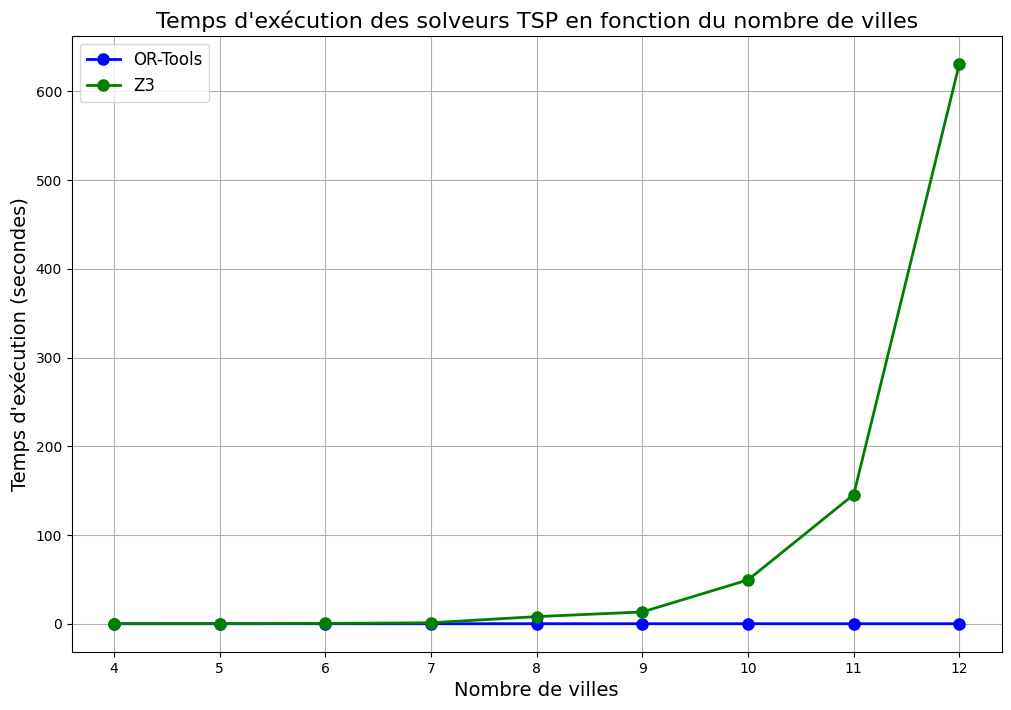

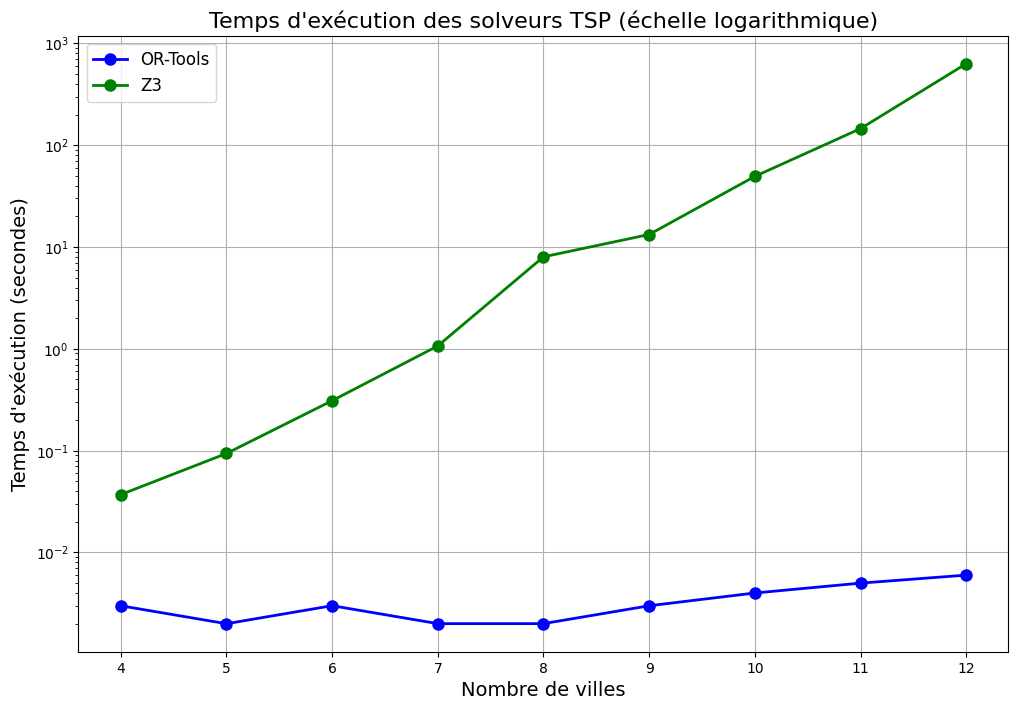

In [8]:
# Création du graphique
plt.figure(figsize=(12, 8))

# Couleurs pour chaque solveur
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for (solver_name, data), color in zip(times.items(), colors):
    if data:  # S'il y a des données pour ce solveur
        x_values = [x for x, _ in data]
        y_values = [y for _, y in data]
        plt.plot(x_values, y_values, 'o-', label=solver_name, color=color, linewidth=2, markersize=8)

plt.xlabel('Nombre de villes', fontsize=14)
plt.ylabel('Temps d\'exécution (secondes)', fontsize=14)
plt.title('Temps d\'exécution des solveurs TSP en fonction du nombre de villes', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(list(cities_range))

# Sauvegarde du graphique
plt.savefig('benchmark_tsp/tsp_benchmark_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Graphique en échelle logarithmique pour mieux voir les différences
plt.figure(figsize=(12, 8))

for (solver_name, data), color in zip(times.items(), colors):
    if data:  # S'il y a des données pour ce solveur
        x_values = [x for x, _ in data]
        y_values = [y for _, y in data]
        plt.plot(x_values, y_values, 'o-', label=solver_name, color=color, linewidth=2, markersize=8)

plt.xlabel('Nombre de villes', fontsize=14)
plt.ylabel('Temps d\'exécution (secondes)', fontsize=14)
plt.title('Temps d\'exécution des solveurs TSP (échelle logarithmique)', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(list(cities_range))
plt.yscale('log')  # Échelle logarithmique pour l'axe y

# Sauvegarde du graphique
plt.savefig('benchmark_tsp/tsp_benchmark_results_log.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Affichage des résultats sous forme de tableau
import pandas as pd
from IPython.display import display, HTML

# Préparation des données pour le tableau
data = []

for n_cities in cities_range:
    row = {'Nombre de villes': n_cities}
    
    for solver in solvers:
        # Recherche des résultats pour ce solveur et ce nombre de villes
        matching_results = [r for r in results[solver] if r[0] == n_cities]
        
        if matching_results and matching_results[0][1] is not None:
            row[f"{solver} (temps)"] = f"{matching_results[0][1]:.4f}s"
            row[f"{solver} (longueur)"] = f"{matching_results[0][2]:.2f}"
        else:
            row[f"{solver} (temps)"] = "N/A"
            row[f"{solver} (longueur)"] = "N/A"
    
    data.append(row)

# Création et affichage du tableau
results_df = pd.DataFrame(data)
display(HTML(results_df.to_html(index=False)))

Nombre de villes,OR-Tools (temps),OR-Tools (longueur),Z3 (temps),Z3 (longueur)
4,0.0030s,1904.30,0.0370s,1904.30
5,0.0020s,2122.30,0.0938s,2122.30
6,0.0030s,2276.98,0.3095s,2276.98
7,0.0020s,2301.52,1.0683s,2301.52
8,0.0020s,2413.55,8.0087s,2413.55
9,0.0030s,2418.93,13.2690s,2418.93
10,0.0040s,2507.64,49.3910s,2507.64
11,0.0050s,2606.64,145.5362s,2606.64
12,0.0060s,2650.96,631.2271s,2650.96
